In [3]:
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
from igraph import *
import cairo
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

ModuleNotFoundError: No module named 'cairo'

In [4]:
import sys
import csv
import json
import pprint
from pymongo import MongoClient
import numpy as np
import collections
from bson.son import SON
from time import time

In [5]:
import pprint

def SaveDict(filename, mode, root):
    if filename[-4:]!=".txt":
        filename+=".txt"
    with open(filename, mode) as f:
        f.write(pprint.pformat(root))

def LoadDict(filename):
    if filename[-4:]!=".txt":
        filename+=".txt"
    with open(filename, "r") as f:
        return eval(f.read())

In [6]:
client = MongoClient()
db = client.twitter

In [7]:
def add_weight_to_user(entry):
    if "weight" in entry:
        return
    else:
        print (entry["user"]["id"])
        pop = db.posts.find_one({"id": entry["tweet_id"]})["retweet_count"]
        if pop > 1e-8:
            db.users.update({"_id": entry["_id"]}, {"$set": {"weight": 1.0/float(pop)}})
        else:
            db.users.update({"_id": entry["_id"]}, {"$set": {"weight": 0.0}})
    return

In [14]:
def merge_users():
    for entry in db.users.find():
        add_weight_to_user(entry)
    pipeline = [{"$group": {"_id": "$user.id", "name": {"$first": "$user.name"}, "tweet_ids": {"$addToSet": "$tweet_id"},
                 "count": {"$sum": 1}, "totalvalue": {"$sum": "$weight"}}},
                {"$out": "user_merge"}]
    db.command('aggregate', 'users', pipeline=pipeline, explain=True)

In [8]:
def generate_links_from_retweet_list(entry):
    retweeters = entry["retweeters"]
    tweet_id = entry["tweet_id"]
    if db.links.find_one({"tweet_id": tweet_id}):
        return
    else:
        documents = []
        for user1 in retweeters:
            for user2 in retweeters:
                if user1 != user2:
                    if db.active_users.find_one({"_id": user1}) and db.active_users.find_one({"_id": user2}):
                        pop = db.posts.find_one({"id": tweet_id})["retweet_count"]
                        if pop > 1e-8:
                            documents.append({"user1": user1, "user2": user2, "tweet_id": tweet_id, "weight": 1.0/float(pop)})
                        else:
                            documents.append({"user1": user1, "user2": user2, "tweet_id": tweet_id, "weight": 0.0})

        print (len(documents))
        if len(documents) > 0:
            db.links.insert_many(documents)
        return

In [9]:
def build_links(start_over=False):
    if start_over:
        db.links.drop()
    count = 0
    for entry in db.retweeter_list.find():
        count += 1
        if count%1000 == 0:
            print (count)
        generate_links_from_retweet_list(entry)

In [10]:
def merge_links(): 
    db.link_merge.drop()
    pipeline = [{"$group": {"_id": {"user1": "$user1", "user2": "$user2"}, "tweet_ids": {"$addToSet": "$tweet_id"}, "value": {"$sum": "$weight"}}},
                {"$addFields": {"number_tweets": {"$size": "$tweet_ids"}}},
                {"$sort":  SON([("value", -1)])},
                {"$out": "link_merge"}]
    db.command('aggregate', 'links', pipeline=pipeline, explain=True)

In [11]:
def calculate_cosine(entry):
    user1 = entry["user1"][0]
    user2 = entry["user2"][0]
    value = float(entry["value"])/float(user1["totalvalue"])/float(user2["totalvalue"])
    db["link_merge"].update({"_id.user1": entry["_id"]["user1"], "_id.user2": entry["_id"]["user2"]}, {"$set": {"similarity": value}})
    return

In [12]:
def cosine_similarity():
    count = 0
    t0 = time()
    for entry in db["link_merge"].find(no_cursor_timeout=True):
        if "similarity" not in entry:
            calculate_cosine(entry)
            count += 1
            if count%1000 == 0:
                print ("count: ", count)
                print("done in %0.3fs." % (time() - t0))
                t0 = time()

In [15]:
t0 = time()
print ("create users collections with a list of retweets...")
merge_users()
print("done in %0.3fs." % (time() - t0))

create users collections with a list of retweets...
done in 0.017s.


In [16]:
t0 = time()
print ("building links for each retweet...")
build_links()
print("done in %0.3fs." % (time() - t0))

building links for each retweet...
done in 0.001s.


In [17]:
t0 = time()
print ("Merging links together...")
merge_links()
print("done in %0.3fs." % (time() - t0))

Merging links together...
done in 0.013s.


In [18]:
t0 = time()
print ("Calculating cosine similarity for the links...")
cosine_similarity()
print("done in %0.3fs." % (time() - t0))

Calculating cosine similarity for the links...
done in 0.003s.


/home/thanh/Documents/NMXLNNTN/seminar/venv/lib/python3.9/site-packages/pymongo/collection.py:1610: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://mongodb.com/docs/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout-overrides-nocursortimeout
  return Cursor(self, *args, **kwargs)


In [21]:
users = db["active_users"]
links = db["link_similarity"]

nodes = {}
ids = []
i = 0
for user in users.find():
    nodes[i] ={"name": user["name"], "value": user["count"]}
    ids.append(user["_id"])
    i += 1
print ("number of nodes: ", len(nodes))
print(nodes)

number of nodes:  0
{}


In [23]:
edges = {}
for link in links.find():
    if link["_id"]["user1"] in ids and link["_id"]["user2"] in ids:
        if ids.index(link["_id"]["user1"]) < ids.index(link["_id"]["user2"]) :
            edges[(ids.index(link["_id"]["user1"]), ids.index(link["_id"]["user2"]))] = {"weight": link["similarity"], "number_tweets": link["number_tweets"]}
print ("number of edges: ", len(edges))

number of edges:  0


In [24]:
graph = {"nodes": nodes, "edges": edges}
SaveDict("./data/network", "w", graph)

FileNotFoundError: [Errno 2] No such file or directory: './data/network.txt'

In [25]:
graph = LoadDict("./data/network")
g = Graph(graph["edges"].keys())
g.vs["name"] = [graph["nodes"][node]["name"] for node in graph["nodes"]]
g.vs["value"] = [graph["nodes"][node]["value"] for node in graph["nodes"]]
g.es["weight"] = [graph["edges"][edge]["weight"] for edge in graph["edges"]]

FileNotFoundError: [Errno 2] No such file or directory: './data/network.txt'

In [26]:
dendrogram_fastgreedy = g.community_fastgreedy(weights=g.es["weight"])

NameError: name 'g' is not defined

In [27]:
n_list_fastgreedy = [500, 200, 180, 170, 160, 150, 100, 80, 70, 60, 50, 40, 30, 20, 10, 5]
modularity_fastgreedy = []
for n in n_list_fastgreedy:
    clusters = dendrogram_fastgreedy.as_clustering(n=n)
    membership_fastgreedy = clusters.membership
    modularity = g.modularity(membership_fastgreedy)
    modularity_fastgreedy.append(modularity)
print (modularity_fastgreedy)

NameError: name 'dendrogram_fastgreedy' is not defined

In [28]:
dendrogram_walktrap = g.community_walktrap(weights=g.es["weight"])

NameError: name 'g' is not defined

In [29]:
n_list_walktrap = [500, 200, 180, 170, 160, 150]
modularity_walktrap = []
for n in n_list_walktrap:
    clusters = dendrogram_walktrap.as_clustering(n=n)
    membership_walktrap = clusters.membership
    modularity = g.modularity(membership_walktrap)
    modularity_walktrap.append(modularity)

NameError: name 'dendrogram_walktrap' is not defined

In [30]:
sns.set_context("poster")
plt.figure()
with sns.axes_style("darkgrid"):
    plt.plot(n_list_fastgreedy, modularity_fastgreedy, label="fast greedy")
    plt.plot(n_list_walktrap, modularity_walktrap, label="walktrap")
    plt.ylim(0.1,)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Modularity")
    plt.legend()
    plt.show()

NameError: name 'sns' is not defined

In [14]:
n_opt = n_list_fastgreedy[np.argmax(np.array(modularity_fastgreedy))]
print n_opt, np.max(modularity_fastgreedy)

10 0.150924155295


In [15]:
clusters = dendrogram_fastgreedy.as_clustering(n=n_opt)
membership_fastgreedy = clusters.membership
modularity = g.modularity(membership_fastgreedy)
print modularity

0.150924155295


(array([1144, 1654, 1182, 1377,  575,  549,    1,    1,    1,    1]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))


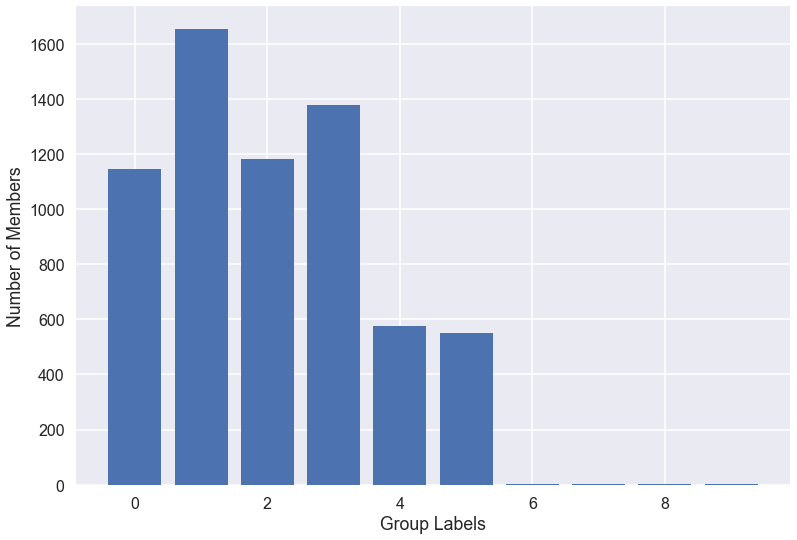

In [16]:
hist = np.histogram(membership_fastgreedy, bins=range(min(membership_fastgreedy), max(membership_fastgreedy)+2))
print hist
labels = range(min(membership_fastgreedy), max(membership_fastgreedy)+1)
with sns.axes_style("darkgrid"):
    plt.bar(labels, hist[0])
    plt.xlabel("Group Labels")
    plt.ylabel("Number of Members")
    plt.show()

In [17]:
for i in range(len(membership_fastgreedy)):
    if hist[0][membership_fastgreedy[i]] < 10:
        membership_fastgreedy[i] = 5

[1144 1654 1182 1377  575  553]


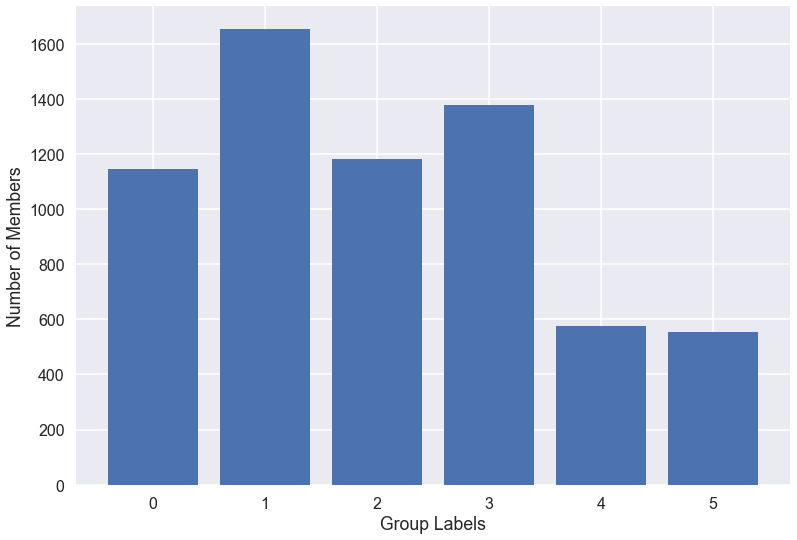

In [18]:
hist = np.histogram(membership_fastgreedy, bins=range(min(membership_fastgreedy), max(membership_fastgreedy)+2))
print hist[0]
labels = range(min(membership_fastgreedy), max(membership_fastgreedy)+1)
with sns.axes_style("darkgrid"):
    plt.bar(labels, hist[0])
    plt.xlabel("Group Labels")
    plt.ylabel("Number of Members")
    plt.show()

In [20]:
SaveDict("./data/label", "w", {"group": membership_fastgreedy})

In [ ]:
group = LoadDict("./data/label")["group"]
g.vs["group"] = group

In [69]:
g_sub = g.subgraph_edges([edge for edge in graph["edges"] if graph["edges"][edge]["weight"] > 10], delete_vertices=True)

In [70]:
summary(g_sub)

IGRAPH UNW- 277 250 -- 
+ attr: group (v), name (v), value (v), weight (e)


In [ ]:
color_dict = {0: "blue", 1: "pink", 2: "red", 3: "green", 4: "yellow", 5:"purple"}
layout = g.layout("kk")
plot(g_sub, layout = layout, vertex_color = [color_dict[group] for group in g.vs["group"]], vertex_size=1)

In [26]:
users = db["active_users"]

In [29]:
for i in range(len(membership_fastgreedy)):
    users.update_one({"name": g.vs["name"][i]}, {"$set": {"label": membership_fastgreedy[i]}})

In [75]:
db.articles.update_many({}, {"$unset": {"label":""}}, upsert=True)
for entry in db.retweeter_list.find():
    retweets = entry["retweeters"]
    votes = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}
    count = 0
    for user in retweets:
        if db.active_users.find_one({"_id":user}):
            votes[int(db.active_users.find_one({"_id":user})["label"])] += 1
            count += 1
    new_fields = {}
    for i in votes:
        new_fields["group "+str(i)] = votes[i]
        
    label = max(votes.iteritems(), key=operator.itemgetter(1))[0]
    if count > 0 and votes[label]/float(count) > 0.5:
        new_fields["label"] = label

    db.articles.update_one({"id": entry["tweet_id"]}, {"$set": new_fields})